In [28]:
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
plt.rcParams.update({'font.size': 18})
import os
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u

In [29]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import make_lightcurve, listdir_contains
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [30]:
# Restore the output directory.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the location of the products made from the "generate_products" notebook.
%store -r data_directory
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the location of the output products.
#data_directory = "./raw_files/"

In [31]:
# Restore the skypos parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the sky position to use.
%store -r skypos
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the sky position in degrees.
#skypos = (24.76279, -17.94948)

In [32]:
# Locate the photon files.
photon_files = {'NUV':listdir_contains(data_directory,'nd.csv'),
                'FUV':listdir_contains(data_directory,'fd.csv')}

In [34]:
# Since this flare has such a large count rate, we can make a 5-second light curve to explore it's shape in detail.
# Flare #8 is in Visit #5 (index 4 in our array of .csv files.)
lc_nuv = make_lightcurve(photon_files['NUV'][4], 'NUV', stepsz=5., skypos=skypos, quiet=True, makefile=False)
lc_fuv = make_lightcurve(photon_files['FUV'][4], 'FUV', stepsz=5., skypos=skypos, fixed_t0=lc_nuv['t0'].min(),
                             quiet=True, makefile=False)

In [35]:
# Read in FUV and NUV effective area curves from the SVO Profile Filter Service.  Effective area curves are in cm**2.
fuv_wls, fuv_effareas = np.genfromtxt("GALEX_GALEX.FUV.dat.txt", unpack=True, dtype=float)
nuv_wls, nuv_effareas = np.genfromtxt("GALEX_GALEX.NUV.dat.txt", unpack=True, dtype=float)

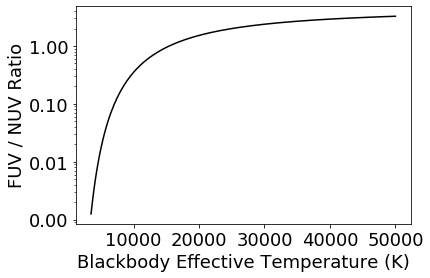

3500 0.0012520198380976061
3750 0.002225259372797934
4000 0.003684331000389733
4250 0.005753118596241778
4500 0.00855436348875211
4750 0.012204319775466764
5000 0.01680853583388134
5250 0.022458865306259474
5500 0.029231648850001794
5750 0.03718691307461296
6000 0.04636839094033785
6250 0.05680416203605636
6500 0.06850772720010778
6750 0.08147935900606089
7000 0.09570760031064797
7250 0.11117081283595871
7500 0.12783870422417495
7750 0.145673784163751
8000 0.16463271790994044
8250 0.1846675591556639
8500 0.20572685431696414
8750 0.2277566175091526
9000 0.2507011804077593
9250 0.27450392434543625
9500 0.2991079038393807
9750 0.32445637163519475
10000 0.3504932155760974
10250 0.37716331737801145
10500 0.4044128428735004
10750 0.43218947259932816
11000 0.46044258082811135
11250 0.48912337034273407
11500 0.5181849694622706
11750 0.5475824970750002
12000 0.5772731007327743
12250 0.6072159722188677
12500 0.6373723444214168
12750 0.6677054728258177
13000 0.698180604479375
13250 0.728764936876

In [54]:
# Compute the expected FUV/NUV ratios in the GALEX passbands for a variety of blackbody temperatures, following the
# work done by Robinson et al. 2005, ApJ, 633, 447.
blackbody_temps = np.arange(3500, 50100, 250)
fuv_nuv_ratios = []
for temp in blackbody_temps:
    # blackbody_lambda returns fluxes in erg/cm**2/s/Angstrom/sr.  Multiplying by effective area curve gets fluxes
    # in erg/s/Angstrom/sr.  Multiplying by the FUV and NUV effective widths results in erg/s/sr.
    bb_cont_fuv = blackbody_lambda(in_x=fuv_wls, temperature=temp * u.Kelvin) * fuv_effareas / np.trapz(fuv_wls,
                                                                                                        fuv_effareas)
    bb_cont_nuv = blackbody_lambda(in_x=nuv_wls, temperature=temp * u.Kelvin) * nuv_effareas / np.trapz(nuv_wls,
                                                                                                       nuv_effareas)
    fuv_nuv_ratio = np.trapz(fuv_wls, bb_cont_fuv) / np.trapz(nuv_wls, bb_cont_nuv)
    fuv_nuv_ratios.append(fuv_nuv_ratio)
# Convert to a numpy array so we can use the where() functionality.
fuv_nuv_ratios = np.asarray(fuv_nuv_ratios)
# Plot the evolution of the FUV to NUV ratio as a function of blackbody temperature.
fig, ax = plt.subplots(1)
ax.plot(blackbody_temps, fuv_nuv_ratios, '-k')
ax.semilogy()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("Blackbody Effective Temperature (K)")
ax.set_ylabel("FUV / NUV Ratio")
plt.show()

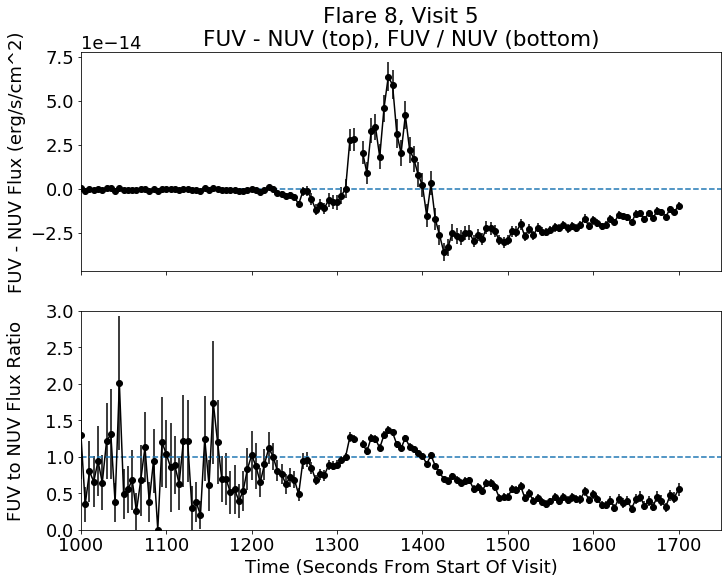

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
# FUV - NUV flux difference and propagated uncertainties: delta_z = SQRT(delta_x**2 + delta_y**2)
diff = lc_fuv['flux_apcorrected'] - lc_nuv['flux_apcorrected']
diff_err = (lc_nuv['flux_err']**2. + lc_fuv['flux_err']**2.)**0.5
ax1.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])), diff, yerr=diff_err, fmt='-ko')
ax1.set_xlim(1000., 1750.)
ax1.axhline(0.0, linestyle='--')
ax1.set_ylabel("FUV - NUV Flux (erg/s/cm^2)")
ax1.set_title("Flare 8, Visit 5\nFUV - NUV (top), FUV / NUV (bottom)")

# FUV / NUV flux ratio and propated uncertainties: delta_z / z = SQRT((delta_x/x)**2 + (delta_y/y)**2)
ratio = lc_fuv['flux_apcorrected'] / lc_nuv['flux_apcorrected']
ratio_err = ratio * ((lc_nuv['flux_err']/lc_nuv['flux_apcorrected'])**2. +
                     (lc_fuv['flux_err']/lc_fuv['flux_apcorrected'])**2.)**0.5
ax2.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])), ratio, yerr=ratio_err, fmt='-ko')
ax2.set_xlim(1000., 1750.)
ax2.set_ylim(0., 3.)
ax2.axhline(1.0, linestyle='--')
ax2.set_xlabel("Time (Seconds From Start Of Visit)")
ax2.set_ylabel("FUV to NUV Flux Ratio", labelpad=20)
fig.savefig("figures/flare8_diff-and-ratio.eps", dpi=600)

In [52]:
# What is the maximum and minimum FUV/NUV ratio once the flare starts?
flare_start_time = 1200.
where_flare = np.where(lc_nuv['t0']-min(lc_nuv['t0']) >= flare_start_time)[0]
min_ratio = np.nanmin(ratio[where_flare])
max_ratio = np.nanmax(ratio[where_flare])
print("Min. and Max. FUV/NUV Ratio During Flare: {0:f} and {1:f}.".format(min_ratio, max_ratio))

Min. and Max. FUV/NUV Ratio During Flare: 0.290751 and 1.368307.


In [56]:
# What would the approximate blackbody temperature be for these ratios assuming the flux is dominated by blackbody
# emission?
where_min = np.argmin(abs(fuv_nuv_ratios - min_ratio))
where_max = np.argmin(abs(fuv_nuv_ratios - max_ratio))
print("Approximate blackbody temperature at minimum ratio of {0:f}: {1:f}".format(min_ratio,
                                                                                  blackbody_temps[where_min]))
print("Approximate blackbody temperature at maximum ratio of {0:f}: {1:f}".format(max_ratio,
                                                                                  blackbody_temps[where_max]))

Approximate blackbody temperature at minimum ratio of 0.290751: 9500.000000
Approximate blackbody temperature at maximum ratio of 1.368307: 18500.000000
